## 0. Notebook description

Based on the findings of the previous notebooks, this notebook uses 6 convolutional layers with average pooling in all layers except the first. It also uses our custom flatten function, as the performance was worse with global average pooling. In this notebook, however, we have added **simple augmentation** (horizontal flip, crop, rotation) to increase the number of input images.

## 1. Importing libraries and loading the data

In [1]:
# Import Libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report
from utils.preprocessing import oversample_data, load_data, ReshapeAndScale, create_dataloaders
from utils.fer2013_dataset import Fer2013Dataset
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

First, we load the data into a pandas dataframe.

In [2]:
train_df = load_data("data/oversampled_train.csv")
val_df = load_data("data/validation.csv")

print("Training Data")
print(train_df.head(10))

print("\n\nValidation Data")
print(val_df.head(10))

   emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
5        2  55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...
6        4  20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
7        3  77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
8        3  85 84 90 121 101 102 133 153 153 169 177 189 1...
9        2  255 254 255 254 254 179 122 107 95 124 149 150...


In [3]:
print("Training data shape:", train_df.shape)
print("Validation data shape", val_df.shape)

(28709, 2)

## 3. Define a custom dataset
We define a custom PyTorch dataset class, `Fer2013Dataset`, for handling the FER2013 data. The dataset is designed to load images (stored as pixel strings) and their corresponding emotion labels. It also supports optional transformations to preprocess the images during training. This setup makes it easy to integrate the dataset with PyTorch DataLoaders.

The class is contained in the `utils/fer2013_dataset` file

We also apply the following preprocessing steps to convert the data into the desired format we can further work with:
1. **Reshaping**:
   - Convert the pixel string into a `48x48` matrix for visualization and processing.
2. **Scaling**:
   - Scale pixel values to the range `[0, 1]` by dividing the pixel values by 255.
3. **Normalization**:
   - Normalize pixel values to the range `[-1, 1]` by subtracting the mean and diving them by the standard deviation.


These preprocessing steps are contained in the class `ReshapeAndScale`, which is available under path `utils/preprocessing.py`.

In [ ]:
# Define a default transformation pipeline
transform = transforms.Compose([
    ReshapeAndScale(n_rows=48, n_cols=48),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

### Define augmentation pipelines

In [ ]:
# Augmentation Pipelines
transform_original = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

transform_1 = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

transform_2 = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

transform_3 = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomCrop(size=(48, 48), padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

In [33]:
class Fer2013Dataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert pixel string to a numpy array
        pixel_string = self.data.iloc[idx]['pixels']
        pixel_array = np.fromstring(pixel_string, sep=' ').astype(np.uint8)
        image = pixel_array.reshape(48, 48)  # FER2013 images are 48x48 pixels

        # Convert numpy array to PIL Image
        image = Image.fromarray(image)

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        # Get the label
        label = self.labels.iloc[idx]

        return image, label

In [34]:
original_train_dataset = Fer2013Dataset(train_df, train_df['emotion'], transform=transform_original)  # Original dataset (no augmentation)

# Create augmented datasets with different pipelines
augmented_train_dataset_1 = Fer2013Dataset(train_df, train_df['emotion'], transform=transform_1)  # Augmented with HorizontalFlip and Rotation
augmented_train_dataset_2 = Fer2013Dataset(train_df, train_df['emotion'], transform=transform_2)  # Augmented with Rotation
augmented_train_dataset_3 = Fer2013Dataset(train_df, train_df['emotion'], transform=transform_3)  # Augmented with Crop and HorizontalFlip

# Combine all datasets
combined_train_dataset = ConcatDataset([original_train_dataset, augmented_train_dataset_1, augmented_train_dataset_2, augmented_train_dataset_3])

val_dataset = Fer2013Dataset(val_df, val_df['emotion'], transform=transform)

print("Combined Dataset Size:", len(combined_train_dataset))

Combined Dataset Size: 202020


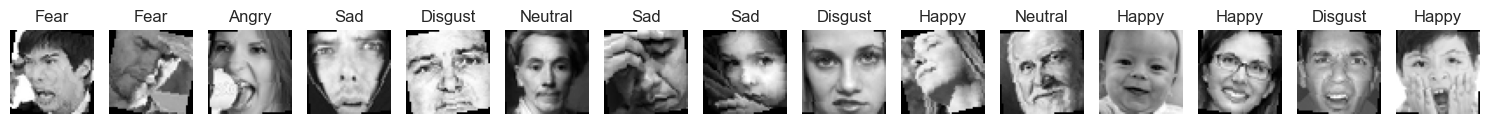

In [35]:
emotion_labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Define a function to visualize images and labels
def show_fake_data_examples(dataset, emotion_labels, num_examples=9):
    """Visualize examples from the FakeData dataset."""
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))
    for i in range(num_examples):
        # Fetch a random image and label from the dataset
        image, label = dataset[i]

        # Convert the image tensor to a numpy array for visualization
        image = image.numpy().squeeze()  # Remove channel dimension if present

        # Display the image
        ax = axes[i]
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        ax.set_title(emotion_labels[label])
    plt.tight_layout()
    plt.show()

# Display some fake data examples
show_fake_data_examples(augmented_train_dataset_2, emotion_labels, num_examples=15)


### Create DataLoaders

We create DataLoaders for both subsets to enable batch processing. The training DataLoader shuffles the data for better learning, while the validation DataLoader does not. Finally, we print the shapes of the batches to verify that everything works correctly.

In [ ]:
batch_size = 32
train_loader, val_loader = create_dataloaders(combined_train_dataset, val_dataset, batch_size)

Train Batch Shape: torch.Size([32, 1, 48, 48]) Train Labels Shape: torch.Size([32])
Train Batch Shape: torch.Size([32, 1, 48, 48]) Train Labels Shape: torch.Size([32])
Train Batch Shape: torch.Size([32, 1, 48, 48]) Train Labels Shape: torch.Size([32])
Train Batch Shape: torch.Size([32, 1, 48, 48]) Train Labels Shape: torch.Size([32])
Train Batch Shape: torch.Size([32, 1, 48, 48]) Train Labels Shape: torch.Size([32])
Train Batch Shape: torch.Size([32, 1, 48, 48]) Train Labels Shape: torch.Size([32])
Train Batch Shape: torch.Size([32, 1, 48, 48]) Train Labels Shape: torch.Size([32])
Train Batch Shape: torch.Size([32, 1, 48, 48]) Train Labels Shape: torch.Size([32])
Train Batch Shape: torch.Size([32, 1, 48, 48]) Train Labels Shape: torch.Size([32])
Train Batch Shape: torch.Size([32, 1, 48, 48]) Train Labels Shape: torch.Size([32])
Train Batch Shape: torch.Size([32, 1, 48, 48]) Train Labels Shape: torch.Size([32])
Train Batch Shape: torch.Size([32, 1, 48, 48]) Train Labels Shape: torch.Siz

## 4. Define the CNN model

We define a custom Convolutional Neural Network (CNN) for emotion recognition. The model includes multiple convolutional layers with batch normalization, dropout for regularization, max pooling for downsampling, and fully connected layers for classification. 

The network dynamically calculates the flattened size needed for the fully connected layers based on the input size (48x48 grayscale images). Finally, we instantiate the model, move it to the available device (CPU or GPU), and print its architecture for verification.


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # 1st Conv Layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding='valid')
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.25)

        # 2nd Conv Layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        # 3rd Conv Layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='valid')
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout(0.25)

        # 4th Conv Layer
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)

        # 5th Conv Layer
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding='valid')
        self.bn5 = nn.BatchNorm2d(128)
        self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)

        # 6th Conv Layer
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same')
        self.bn6 = nn.BatchNorm2d(256)
        self.pool6 = nn.AvgPool2d(kernel_size=2, stride=2)

        # Add Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Fully Connected Layer
        self.fc = nn.Linear(256, 7)  # 7 classes for emotion recognition

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool4(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.pool5(x)

        x = self.conv6(x)
        x = self.bn6(x)
        x = F.relu(x)
        x = self.pool6(x)

        # Global Average Pooling
        x = self.gap(x)

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Fully Connected Layer
        x = self.fc(x)

        return x

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN()
model = model.to(device)

# Print the model structure
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=val

## 5. Define Loss Function and Optimizer

In this cell, we define the loss function and optimizer for training the model:
- **Loss Function**: `CrossEntropyLoss` is used, which is well-suited for multi-class classification tasks like emotion recognition.
- **Optimizer**: The Adam optimizer is initialized with a learning rate of `0.0001` to update the model parameters during training.

In [13]:
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # call optimizer

## 6. Train the Model

In this cell, we define the training loop for the CNN:
- **Number of Epochs**: The model is trained for 35 epochs.
- **Training Process**:
  - The model is set to training mode.
  - For each batch, we move inputs and labels to the appropriate device, clear the gradients, perform forward and backward passes, and update the model's parameters using the optimizer.
  - The running loss is tracked and printed every 100 batches for monitoring.

In [ ]:
# Initialize TensorBoard writer
writer = SummaryWriter(log_dir='tensorboard-runs/7_Group17_DLProject')

checkpoint_path = 'model-checkpoints/7_Group17_DLProject'
os.makedirs(checkpoint_path, exist_ok=True)

num_epochs = 35
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 100 == 0:  # Print every 100 batches
            avg_loss = running_loss / 100
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {avg_loss:.4f}")
            running_loss = 0.0

            # Log loss to TensorBoard
            writer.add_scalar('Loss/train', avg_loss, epoch)

    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss,
        }
        torch.save(checkpoint, f"{checkpoint_path}/checkpoint_epoch_{epoch + 1}.pth")
        print(f"Checkpoint saved at epoch {epoch + 1}")

# Close the writer after training
writer.close()

Epoch [1/35], Step [100/1263], Loss: 1.9293
Epoch [1/35], Step [200/1263], Loss: 1.8742
Epoch [1/35], Step [300/1263], Loss: 1.8231
Epoch [1/35], Step [400/1263], Loss: 1.7793
Epoch [1/35], Step [500/1263], Loss: 1.7405
Epoch [1/35], Step [600/1263], Loss: 1.7022
Epoch [1/35], Step [700/1263], Loss: 1.6561
Epoch [1/35], Step [800/1263], Loss: 1.6427
Epoch [1/35], Step [900/1263], Loss: 1.5581
Epoch [1/35], Step [1000/1263], Loss: 1.5421
Epoch [1/35], Step [1100/1263], Loss: 1.4959
Epoch [1/35], Step [1200/1263], Loss: 1.4638
Epoch [2/35], Step [100/1263], Loss: 1.4038
Epoch [2/35], Step [200/1263], Loss: 1.3926
Epoch [2/35], Step [300/1263], Loss: 1.3575
Epoch [2/35], Step [400/1263], Loss: 1.3363
Epoch [2/35], Step [500/1263], Loss: 1.3307
Epoch [2/35], Step [600/1263], Loss: 1.3116
Epoch [2/35], Step [700/1263], Loss: 1.2676
Epoch [2/35], Step [800/1263], Loss: 1.2571
Epoch [2/35], Step [900/1263], Loss: 1.2357
Epoch [2/35], Step [1000/1263], Loss: 1.2389
Epoch [2/35], Step [1100/126

## 7. Evaluate the Model

In this cell, we evaluate the trained model using the validation dataset:
- The model is set to evaluation mode, and gradient computation is disabled.
- For each batch, we perform a forward pass and predict the class labels.
- Ground truth labels and predictions are stored and used to generate a classification report using `sklearn`. This report provides precision, recall, and F1-scores for each emotion class.

In [ ]:
# Switch model to evaluation mode
model.eval()

# Initialize lists to store ground truth and predictions
y_true, y_pred = [], []

# Disable gradient computation
with torch.no_grad():
    for inputs, labels in val_loader:
        # Move inputs and labels to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Get the predicted class
        _, predicted = torch.max(outputs, 1)

        # Append ground truth and predictions to respective lists
        y_true.extend(labels.cpu().numpy())  # Convert tensors to numpy
        y_pred.extend(predicted.cpu().numpy())

# Generate the classification report
emotion_labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
print(classification_report(y_true, y_pred, target_names=list(emotion_labels.values())))


              precision    recall  f1-score   support

       Angry       0.92      0.92      0.92      5849
     Disgust       0.99      1.00      1.00      5782
        Fear       0.91      0.89      0.90      5776
       Happy       0.96      0.93      0.95      5848
         Sad       0.89      0.90      0.89      5618
    Surprise       0.97      0.96      0.96      5783
     Neutral       0.89      0.92      0.91      5748

    accuracy                           0.93     40404
   macro avg       0.93      0.93      0.93     40404
weighted avg       0.93      0.93      0.93     40404



Using augmentation techniques such as horizontal flip, crop, and rotation significantly increases the accuracy of the model to 0.93. This improvement demonstrates the effectiveness of data augmentation in enhancing the model's ability to generalize and perform better on unseen data.